<a href="https://colab.research.google.com/github/graduate-c/type_I_error_simulator/blob/main/two_sample_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Type I errorのシミュレーター(両側t検定)
## 概要
母平均が同じ2つの母集団から乱数をたくさん生成して、それらに対して平均値の差の検定(両側)を繰り返します。  
p値を集計し、「有意水準αの検定を実施した時の実際のType I error」がどのようになっているかをグラフにします。
## 動作概要
### 標本(乱数)の作成
[wikipedia(一般化正規分布)](https://en.wikipedia.org/wiki/Generalized_normal_distribution)に記載の通り、一般化正規分布(Symmetric version)・一般化正規分布(Asymmetric version)に従う乱数を生成します。  
いずれも指定された分散になるようにパラメータを設定しています。  
分布形状は"shape_1", "shape_2"の変数で変えることができます。Symmetric versionではβ (正の実数、β=2で正規分布)、Asymmetric versionではκ (実数、κ=1で正規分布)パラメーターに対応します。  
### 検定の種類
Z検定、Studenのt検定、Welchの近似t検定、Welch-Aspin検定(optional)を実行し、p値を計算します。  
Welch-Aspin検定は時間がかかる(といっても100,000回実行時にtotalで20秒程度)ので、実行の有無を選べます。  
※Welch-Aspin検定のP値を求める際に、内部で代数方程式の数値解を計算しているため時間がかかっています。  
※Welch-Aspin検定(特に四次)はあまり計算結果に自信がないのでおまけ程度に見てください
### 出力
左に母集団の確率密度関数、右にp値の分布、下にα=0.01, 0.05におけるtype I error rateが描画されます。
## 実行手順
1. 1-5のセルをすべて実行します。
2. 5のセル内のパラメーターを設定します。
3. 6のセルを実行します。
4. パラメーターを変更する場合、5のセル内のパラメーターを設定して6を再実行してください。

In [ ]:
#@title 1. ライブラリのインポート
import math

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import numpy as np
from numpy.polynomial.polynomial import Polynomial
import ipywidgets as widgets
from scipy import stats

In [ ]:
#@title 2. 乱数を作る関数のインポート
rg = np.random.default_rng()

def sym_rand_generator(n, size, var, shape):
    # 対称的な一般化正規分布に基づく乱数を作る関数
    beta = shape
    alpha = math.sqrt(math.gamma(1/beta) / math.gamma(3/beta) * var)
    sample = stats.gennorm.rvs(beta=beta,
                               scale=alpha,
                               size=(n, size))
    return sample
def asym_rand_generator(n, size, var, shape):
    # 非対称的な一般化正規分布に基づく乱数を作る関数
    kappa = shape
    xi = np.sign(kappa) * math.sqrt((math.exp(kappa**2/2)-1)
                                    / math.exp(kappa**2)
                                    / (math.exp(kappa**2/2)+1)
                                    * var)
    alpha = np.abs(kappa) * math.sqrt(var
                                      / math.exp(kappa**2)
                                      / (math.exp(kappa**2) - 1))
    norm = rg.normal(loc=0,
                     scale = 1,
                     size=(n, size))
    sample = (alpha / kappa * (1 - np.exp(-kappa * norm)) + xi)
    return sample

In [ ]:
#@title 3. 確率密度関数のインポート
def sym_genorm( var, shape, x):
    # 対称的な一般化正規分布の確率密度関数関数
    beta = shape
    alpha = math.sqrt(math.gamma(1/beta) / math.gamma(3/beta) * var)
    pdf = stats.gennorm.pdf(x = x,
                            beta=beta,
                            scale=alpha)
    return pdf

def asym_genorm(var, shape, x):
    # 非対称的な一般化正規分布の確率密度関数関数
    kappa = shape
    xi = np.sign(kappa) * math.sqrt((math.exp(kappa**2/2)-1)
                                    / math.exp(kappa**2)
                                    / (math.exp(kappa**2/2)+1)
                                    * var)
    alpha = np.abs(kappa) * math.sqrt(var
                                      / math.exp(kappa**2)
                                      / (math.exp(kappa**2) - 1))
    xtrim = np.where(1 - kappa / alpha * (x - xi)<=0, float("nan"), x)
    pdf = (stats.norm.pdf(x = - (1 / kappa * np.log(1 - kappa / alpha * (xtrim - xi))))
                          / (alpha - kappa * (xtrim - xi)))
    return pdf

In [ ]:
#@title 4. p値を求める関数のインポート
def z_p(sample1, sample2):
    # z検定のp値を求める関数
    n1 = sample1.shape[1]
    n2 = sample2.shape[1]
    mean1 = np.mean(sample1, axis=1)
    mean2 = np.mean(sample2, axis=1)
    var1 = np.var(sample1, axis=1, ddof=1)
    var2 = np.var(sample2, axis=1, ddof=1)
    tval = np.abs((mean1 - mean2)
                  / np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2)
                            /(n1 + n2 - 2)
                            * (1 / n1 + 1 / n2)))
    pvalue = stats.norm.cdf(-tval) * 2
    return pvalue
def ttest_p(scheme, sample1, sample2):
    # t検定のp値を求める関数
    n1 = sample1.shape[1]
    n2 = sample2.shape[1]
    mean1 = np.mean(sample1, axis=1)
    mean2 = np.mean(sample2, axis=1)
    var1 = np.var(sample1, axis=1, ddof=1)
    var2 = np.var(sample2, axis=1, ddof=1)
    if scheme == "Student":
        tval = np.abs((mean1 - mean2)
                      / np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2)
                                / (n1 + n2 - 2)
                                * (1 / n1 + 1 / n2)))
        df = n1 + n2 -2
        pvalue = stats.t.cdf(-tval, df) * 2
    elif scheme == "Welch APDF":
        tval = np.abs((mean1 - mean2)
                      / np.sqrt(var1/n1 + var2/n2))
        df = ((var1 / n1 + var2 / n2)**2
              / ((var1 / n1)**2 / (n1 - 1) + (var2 / n2)**2/(n2 - 1)))
        pvalue = stats.t.cdf(-tval, df) * 2
    return pvalue

# Welch-Aspinの検定のP値を求める関数
def coeff_vt(sample1, sample2, r, u):
    n1 = sample1.shape[1]
    n2 = sample2.shape[1]
    mean1 = np.mean(sample1, axis=1)
    mean2 = np.mean(sample2, axis=1)
    var1 = np.var(sample1, axis=1, ddof=1)
    var2 = np.var(sample2, axis=1, ddof=1)
    numer = var1**r / n1**r / (n1 - 1)**u + var2**r / n2**r / (n2 - 1)**u
    denom = (var1 / n1 + var2 / n2)**r
    v = numer / denom
    return v.reshape([-1, 1])

# Welch-Aspin検定
def welch_aspin_p(sample1, sample2, order):
    num = sample1.shape[0]
    # t検定のp値を求める関数
    n1 = sample1.shape[1]
    n2 = sample2.shape[1]
    mean1 = np.mean(sample1, axis=1)
    mean2 = np.mean(sample2, axis=1)
    var1 = np.var(sample1, axis=1, ddof=1)
    var2 = np.var(sample2, axis=1, ddof=1)
    tval = np.abs((mean1 - mean2)
                  / np.sqrt(var1/n1 + var2/n2))
    # h(s^2)の計算
    if order >= 0:
        # 0次
        hlist = np.tile(np.array([0,1,0,0,0,0,0,0,0,0], dtype = "float64"), (num,1))
    if order >= 1:
        # 1次
        hlist += 1/4 * coeff_vt(sample1,sample2,2,1) * np.tile([0,1,0,1,0,0,0,0,0,0], (num,1))
    if order >= 2:
        # 2次
        hlist += (-1/2 * coeff_vt(sample1,sample2,2,2) * np.tile([0,1,0,1,0,0,0,0,0,0], (num,1))
                  + 1/3 * coeff_vt(sample1,sample2,3,2) * np.tile([0,3,0,5,0,1,0,0,0,0], (num,1))
                  - 1/32 * coeff_vt(sample1,sample2,2,1)**2 * np.tile([0,15,0,32,0,9,0,0,0,0], (num,1)))
    if order >= 3:
        # 3次
        hlist += (1 * coeff_vt(sample1,sample2,2,3) * np.tile([0,1,0,1,0,0,0,0,0,0], (num,1))
                  -2 * coeff_vt(sample1,sample2,3,3) * np.tile([0,3,0,5,0,1,0,0,0,0], (num,1))
                  + 1/8 * (coeff_vt(sample1,sample2,2,2)
                           * coeff_vt(sample1,sample2,2,1)) * np.tile([0,15,0,32,0,9,0,0,0,0], (num,1))
                  + 1/8 * coeff_vt(sample1,sample2,4,3) * np.tile([0,75,0,173,0,63,0,5,0,0], (num,1))
                  - 1/12 * (coeff_vt(sample1,sample2,3,2)
                            * coeff_vt(sample1,sample2,2,1)) * np.tile([0,105,0,298,0,140,0,15,0,0], (num,1))
                  + 1/384 * coeff_vt(sample1,sample2,2,1)**3 * np.tile([0,945,0,3169,0,1811,0,243,0,0], (num,1)))
    if order >= 4:
        # 4次
        hlist += (-2 * coeff_vt(sample1,sample2,2,4) * np.tile([0,1,0,1,0,0,0,0,0,0], (num,1))
                  +28/3 * coeff_vt(sample1,sample2,3,4) * np.tile([0,3,0,5,0,1,0,0,0,0], (num,1))
                  - 1/4 * (1/2 * coeff_vt(sample1,sample2,2,2)**2
                           + coeff_vt(sample1,sample2,2,3)
                           * coeff_vt(sample1,sample2,2,1)) * np.tile([0,15,0,32,0,9,0,0,0,0], (num,1))
                  - 3/2 * coeff_vt(sample1,sample2,4,4) * np.tile([0,75,0,173,0,63,0,5,0,0], (num,1))
                  + 1/2 * (1/3 * coeff_vt(sample1,sample2,2,2)
                           * coeff_vt(sample1,sample2,3,2)
                           + coeff_vt(sample1,sample2,2,1)
                           * coeff_vt(sample1,sample2,3,3)) * np.tile([0,105,0,298,0,140,0,15,0,0], (num,1))
                  + 1/4 * coeff_vt(sample1,sample2,4,4) * np.tile([0,15,0,33,0,11,0,1,0,0], (num,1))
                  + 1/5 * coeff_vt(sample1,sample2,5,4) * np.tile([0,735,0,2170,0,1126,0,168,0,7], (num,1))
                  - 1/64 * (coeff_vt(sample1,sample2,2,2)
                            * coeff_vt(sample1,sample2,2,1)**2) * np.tile([0,945,0,3169,0,1811,0,243,0,0], (num,1))
                  - 1/18 * coeff_vt(sample1,sample2,3,2)**2 * np.tile([0,945,0,3354,0,2166,0,425,0,25], (num,1))
                  - 1/32 * (coeff_vt(sample1,sample2,2,1)
                            * coeff_vt(sample1,sample2,4,3)) * np.tile([0,4725,0,16586,0,10514,0,1974,0,105], (num,1))
                  + 1/96 * (coeff_vt(sample1,sample2,3,2)
                            * coeff_vt(sample1,sample2,2,1)**2) * np.tile([0,10395,0,42429,0,31938,0,7335,0,495], (num,1))
                  - 1/6144 * coeff_vt(sample1,sample2,2,1)**4 * np.tile([0,135135,0,626144,0,542026,0,145320,0,11583], (num,1)))
    # 左辺？を移項
    hlist[:, 0] = -tval
    # 等式の解のうち実数のもの(ξ)を計算
    xiroots = np.array([Polynomial(h).roots() for h in hlist])
    xiroots[np.iscomplex(xiroots)] = 0
    xi = np.sum(xiroots, axis = 1)
    #正規分布を使ってp値に変換
    pvalue = stats.norm.cdf(-xi) * 2
    return pvalue.real

In [ ]:
#@title 5. パラメーターの決定
# @markdown - ここまで(1-5)を最初に実行してください

# @markdown - 下に出てきた欄にパラメーターをいれて6を実行してください

# @markdown - パラメーターを変えるときは、下の欄を変更して6のみを実行してください

xdata = np.linspace(-5, 5, 2000)

# 1つ目のサンプルのパラメーター
func_1 = "asymmetry"
shape_1 = 0
var_1 = 1
# 2つ目のサンプルのパラメーター
func_2 = "asymmetry"
shape_2 = 0
var_2 = 1


wlabel1 = widgets.Label(value = "1つめのサンプル")
wsym1 = widgets.Select(description='分布形状:', value = "asymmetry", options=["symmetry", "asymmetry"], rows=1)
wshape1 = widgets.BoundedFloatText(value=0, min=-10, max=10, step=0.1, description="形状母数:")
wvar1 = widgets.BoundedIntText(value=1, min=0.1, max=10, step=0.1, description="分散:")
wsize1 = widgets.BoundedIntText(value=6, min=2, max=100, step=1, description="サンプルサイズ:",)

wlabel2 = widgets.Label(value = "2つめのサンプル")
wsym2 = widgets.Select(description='分布形状:', value = "asymmetry", options=["symmetry", "asymmetry"], rows=1)
wshape2 = widgets.BoundedFloatText(value=0, min=-10, max=10, step=0.1, description="形状母数:")
wvar2 = widgets.BoundedIntText(value=1, min=0.1, max=10, step=0.1, description="分散:")
wsize2 = widgets.BoundedIntText(value=6, min=2, max=100, step=1, description="サンプルサイズ:",)


def dist_draw(la1, sy1, sh1, va1, si1,
              la2, sy2, sh2, va2, si2):
    global func_1, shape_1, var_1, func_2, shape_2, var_2, size_1, size_2
    fig, ax = plt.subplots()
    ax.set_xlim(-5, 5)
    if (   (sy1 == "symmetry" and sh1 == 2)
        or (sy1 == "asymmetry" and sh1 == 0)):
        pdf_1 = stats.norm.pdf(x = xdata, scale = math.sqrt(va1))
    elif sy1 == "symmetry":
        if sh1 <= 0:
            print("1つめの分布の形状母数を正の実数にしてください")
            plt.show()
            return
        else:
            pdf_1 = sym_genorm(va1, sh1, xdata)
    elif sy1 == "asymmetry":
        pdf_1 = asym_genorm(va1, sh1, xdata)

    if (   (sy2 == "symmetry" and sh2 == 2)
        or (sy2 == "asymmetry" and sh2 == 0)):
        pdf_2 = stats.norm.pdf(x = xdata, scale = math.sqrt(va2))
    elif sy2 == "symmetry":
        if sh2 <= 0:
            print("2つめの分布の形状母数を正の実数にしてください")
            plt.show()
            return
        else:
            pdf_2 = sym_genorm(va2, sh2, xdata)
    elif sy2 == "asymmetry":
      pdf_2 = asym_genorm(va2, sh2, xdata)
    ax.plot(xdata, pdf_1, label = "sample 1")
    ax.plot(xdata, pdf_2, label = "sample 2")
    ax.legend(loc = "upper right")

    # 1つ目のサンプルのパラメーター
    func_1 = sy1
    shape_1 = sh1
    var_1 = va1
    size_1 = si1
    # 2つ目のサンプルのパラメーター
    func_2 = sy2
    shape_2 = sh2
    var_2 = va2
    size_2 = si2

    plt.show()

out = widgets.interactive_output(dist_draw, {"la1": wlabel1,
                                             "sy1": wsym1,
                                             "sh1": wshape1,
                                             "va1": wvar1,
                                             "si1": wsize1,
                                             "la2": wlabel2,
                                             "sy2": wsym2,
                                             "sh2": wshape2,
                                             "va2": wvar2,
                                             "si2": wsize2})
ui = widgets.HBox([widgets.VBox([wlabel1, wsym1, wshape1, wvar1, wsize1]),
                   widgets.VBox([wlabel2, wsym2, wshape2, wvar2, wsize2])])
display(ui, out)

witeration = widgets.BoundedIntText(value=100000, min=100, max=10000000, step=100, description="試行回数:",)
wlabelwa = widgets.Label(value = "Welch-Aspin検定(optional)")
wwaorder = widgets.Select(options=["実行しない", "1次", "2次", "3次", "4次"], value="実行しない", description="次数:", rows = 1)

iter = 100000
wa_bool = False
wa_order = 3
@widgets.interact(it = witeration,
                  wal = wlabelwa,
                  wao = wwaorder)
def dist_draw(it, wal, wao):
    global iter, wa_bool, wa_order
    iter = it
    if wao == "実行しない":
        wa_bool = False
    else:
        wa_bool = True
        wa_order = int(wao[0])

Output()

interactive(children=(BoundedIntText(value=100000, description='試行回数:', max=10000000, min=100, step=100), Labe…

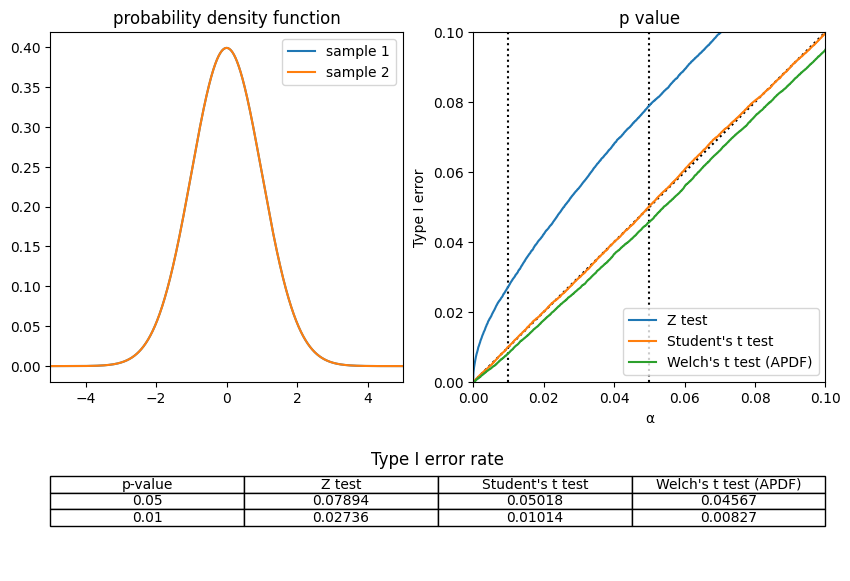

In [ ]:
# @title  6. 検定の実行・描画


## @markdown ##試行回数
#iter = 100000 # @param {type:"integer"}

## @markdown ##Welch-Aspin testの実行
#wa_bool = False # @param {type:"boolean"}
#wa_order = 3 # @param {type:"slider", min:1, max:4, step:1}

## @markdown ##1つめのサンプル
## @markdown サンプルサイズ
#size_1 = 6 # @param {type:"integer"}

## @markdown ##2つめのサンプル
## @markdown サンプルサイズ
#size_2 = 6 # @param {type:"integer"}

# 乱数の生成から描画まで
# 1つめのサンプルの乱数生成
if (   (func_1 == "symmetry" and shape_1 == 2)
    or (func_1 == "asymmetry" and shape_1 == 0)):
    # 通常の正規分布
    sample1 = rg.normal(loc=0,
                        scale=math.sqrt(var_1),
                        size=(iter, size_1))
elif func_1 == "symmetry":
    sample1 = sym_rand_generator(iter, size_1, var_1, shape_1)
elif func_1 == "asymmetry":
    sample1 = asym_rand_generator(iter, size_1, var_1, shape_1)

# 2つめのサンプルの乱数生成
if (   (func_2 == "symmetry" and shape_2 == 2)
    or (func_2 == "asymmetry" and shape_2 == 0)):
    # 通常の正規分布
    sample2 = rg.normal(loc=0,
                        scale=math.sqrt(var_2),
                        size=(iter, size_2))
elif func_2 == "symmetry":
    sample2 = sym_rand_generator(iter, size_2, var_2, shape_2)
elif func_2 == "asymmetry":
    sample2 = asym_rand_generator(iter, size_2, var_2, shape_2)

#グラフの描画
fig = plt.figure(figsize=(10,7))
gs_master = GridSpec(nrows=2, ncols=2, height_ratios=[5, 2])
gs1 = GridSpecFromSubplotSpec(nrows=1, ncols=2, subplot_spec=gs_master[0, 0:2])
ax0 = fig.add_subplot(gs1[:, 0])
ax1 = fig.add_subplot(gs1[:, 1])
gs2 = GridSpecFromSubplotSpec(nrows=1, ncols=2, subplot_spec=gs_master[1, 0:2])
ax2 = fig.add_subplot(gs2[:, :])

ordinal_dict = {1: "1st", 2: "2nd", 3: "3rd", 4: "4th"}


# 確率密度関数の描画
ax0.set_title("probability density function")
ax0.set_xlim(-5, 5)
xdata = np.linspace(-5, 5, 2000)
if (   (func_1 == "symmetry" and shape_1 == 2)
    or (func_1 == "asymmetry" and shape_1 == 0)):
    pdf_1 = stats.norm.pdf(x = xdata, scale = math.sqrt(var_1))
elif func_1 == "symmetry":
    pdf_1 = sym_genorm(var_1, shape_1, xdata)
elif func_1 == "asymmetry":
    pdf_1 = asym_genorm(var_1, shape_1, xdata)
if (   (func_2 == "symmetry" and shape_2 == 2)
    or (func_2 == "asymmetry" and shape_2 == 0)):
    pdf_2 = stats.norm.pdf(x = xdata, scale = math.sqrt(var_2))
elif func_2 == "symmetry":
    pdf_2 = sym_genorm(var_2, shape_2, xdata)
elif func_2 == "asymmetry":
    pdf_2 = asym_genorm(var_2, shape_2, xdata)
ax0.plot(xdata, pdf_1, label = "sample 1")
ax0.plot(xdata, pdf_2, label = "sample 2")
ax0.legend(loc = "upper right")


# p値、eCDFの計算と描画
# グラフフォーマット
ax1.set_xlim(0,0.1)
ax1.set_ylim(0,0.1)
ax1.set_xlabel("α")
ax1.set_ylabel("Type I error")
ax1.set_title("p value")
# 対角線の描画
ax1.plot([0,1], [0,1], linestyle = "dotted", color = "black")
# p値の境界
ax1.plot([0.01,0.01], [0,1], linestyle = "dotted", color = "black")
ax1.plot([0.05,0.05], [0,1], linestyle = "dotted", color = "black")
# p値計算と描画
# Z検定
z_pvalue = z_p(sample1, sample2)
z_ecdf = stats.ecdf(z_pvalue)
z_ecdf.cdf.plot(ax1, label = "Z test")
# Studentのt検定
stdt_pvalue = ttest_p("Student", sample1, sample2)
stdt_ecdf = stats.ecdf(stdt_pvalue)
stdt_ecdf.cdf.plot(ax1, label = "Student's t test")
# Welchのt検定
apdf_pvalue = ttest_p("Welch APDF", sample1, sample2)
apdf_ecdf = stats.ecdf(apdf_pvalue)
apdf_ecdf.cdf.plot(ax1, label = "Welch's t test (APDF)")
# Welch-Aspinの検定
if wa_bool == True:
    wa_pvalue = welch_aspin_p(sample1, sample2, wa_order)
    wa_ecdf = stats.ecdf(wa_pvalue)
    wa_ecdf.cdf.plot(ax1, label = f"Welch-Aspin test ({ordinal_dict[wa_order]})")
# 凡例
ax1.legend(loc = "lower right")

# Type I error rateの表
err_text = [[0.05], [0.01]]
if wa_bool == True:
    pvalues = [z_pvalue, stdt_pvalue, apdf_pvalue, wa_pvalue]
    labels = ["p-value","Z test","Student's t test", "Welch's t test (APDF)", f"Welch-Aspin test ({ordinal_dict[wa_order]})"]
else:
    pvalues = [z_pvalue, stdt_pvalue, apdf_pvalue]
    labels = ["p-value","Z test","Student's t test", "Welch's t test (APDF)"]

for pvalue in pvalues:
    for i in range(2):
        rate = np.count_nonzero(pvalue <= err_text[i][0]) / len(pvalue)
        err_text[i].append(rate)
ax2.axis("off")
ax2.set_title("Type I error rate", y=0.7)
table = ax2.table(cellText=err_text, colLabels=labels, cellLoc="center", loc="center")

# 補足
## 一般化正規分布(Symmetric version)
確率密度関数は  
$$f(x) = \frac{\beta}{2\alpha\Gamma(1/\beta)}e^{-(|x-\mu|/\alpha)^{\beta}}$$
となる。  
尺度母数$\alpha$を、形状母数$\beta$と分散$\sigma^2$で表すと
$$\alpha = \sqrt{\frac{\Gamma(1/\beta)}{\Gamma(3/\beta)}}\sigma$$
となる。  
今回は、形状母数$\beta$ (shape_1, shape_2)と分散$\sigma^2$ (var_1, var_2)で分布を指定する。  
## 一般化正規分布(Asymmetric version)
確率密度関数は、$\kappa \neq 0$で  
$$f(x) = \frac{\phi(y)}{\alpha - \kappa(x - \xi)}\\
y = -\frac{1}{\kappa}log\left(1-\frac{\kappa(x - \xi)}{\alpha}\right)$$
($\phi$は標準正規分布の確率密度関数)  
となる。  
平均0、分散$\sigma^2$を代入して整理すると
$$\alpha = \frac{|\kappa| \cdot \sigma}{\sqrt{e^{\kappa^2}\left(e^{\kappa^2} - 1\right)}}\\
\xi = sign(\kappa) \cdot \sigma \sqrt{\frac{e^{\kappa^2 / 2} - 1}{e^{\kappa^2}\left(e^{\kappa^2/2} + 1\right)}}$$
となる。  
今回は、形状母数$\kappa$ (shape_1, shape_2)と分散$\sigma^2$ (var_1, var_2)で分布を指定する。  